# ------------------- Part B. ANOMALY DETECTION -------------
- The main focus of this notebook is to detect Anomalies in Dataset.
- Using Neural Network concept using Tensor Keras - LSTM AutoEncoder Decoder Model.

### Consist Following Steps
- **Step 1. :** Import necessary libraries & Data
- **Step 2. :** Prepare data
- **Step 3. :** Data Preprocessing
- **Step 4. :** Building & Train LSTM Autoencoder Model
- **Step 5. :** Evaluate LSTM Autoencoder Model
- **Step 6. :** Detect Anomalies on data

### -------------- Step 1 : Import necessary libraries & Data --------------

In [1]:
# import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
import tensorflow as tf
import plotly.express as px
import plotly.graph_objects as go

#supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

rcParams['figure.figsize'] = 10,8
print("Tensorflow version ",tf.__version__)

Tensorflow version  2.3.1


In [2]:
Dataset = pd.read_csv("/Users/ganesh_dhasade/Documents/GitHub/BIG_DataNationalGird/NationalGrid_1_1_12_to_27_9_20.csv")

In [3]:
Dataset = Dataset[['timestamp','demand']]
Dataset.head()

,timestamp,demand
0,2012-01-01 00:00:01,30590
1,2012-01-01 00:05:06,30490
2,2012-01-01 00:10:01,30802
3,2012-01-01 00:15:01,31180
4,2012-01-01 00:20:01,31241


In [4]:
Dataset['timestamp'] = pd.to_datetime(Dataset['timestamp'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')
Dataset=pd.DataFrame(Dataset.groupby('timestamp').demand.sum()).reset_index()

In [5]:
Dataset.head()

,timestamp,demand
0,2012-01-01,9191420
1,2012-01-02,9952561
2,2012-01-03,11585345
3,2012-01-04,12024761
4,2012-01-05,11914665


In [6]:
Dataset['timestamp'] = pd.to_datetime(Dataset['timestamp'])
Dataset.dtypes

timestamp    datetime64[ns]
demand                int64
dtype: object

### -------------------- Step 2 : Prepare data -------------------------

### Observation
- Data contains a daily electricity demand.

In [7]:
# Some helper functions
def VisualizeTrend(dataframe, label):
    plt.gcf().set_size_inches(10, 10)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dataframe.timestamp, y=dataframe.demand, mode='lines', name='demand'))
    fig.update_layout(showlegend=True, title = label, xaxis_title="Date/Time", yaxis_title="Demand - GW",)
    fig.show()
    return None

In [9]:
label = "Daily electricity demand in UK from 2012 - 2020."
VisualizeTrend(Dataset, label)

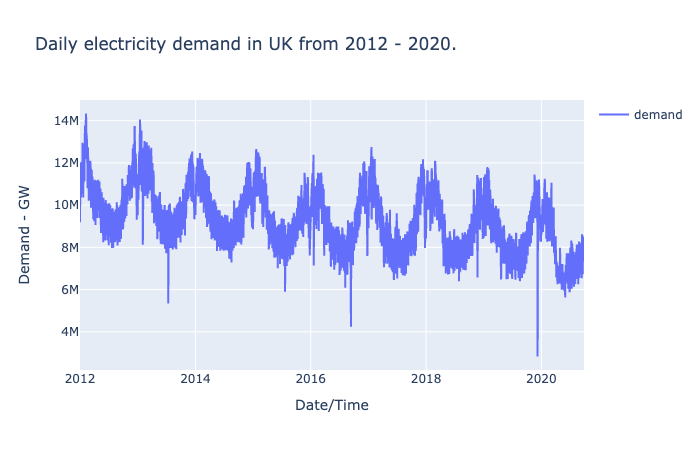

### ------------------- Step 3 : Data Preprocessing -------------------
- 1. Split data into train and test set - 80:20 ratio i.e 
    - approximately Train data from 2012 to 2018  & 
    - Test Data from 2019 to 2020
- 2. Standardizing our target vector by removing the mean and scaling it to unit variance.
    - Scale data between 0 to 1 to minimize the complexity of data .
    - Create the instance of StandarsScaler function and then fit this helper function on the training set and then transform the Train and Test set.

#### 1. Split Data into Train & Test set

In [13]:
train_size = int(len(Dataset)*0.7)
test_size = len(Dataset) - train_size
TrainData,TestData = Dataset.iloc[0:train_size], Dataset.iloc[train_size:len(Dataset)]
print(TrainData.shape,TrainData.shape)

(2235, 2) (2235, 2)


In [14]:
print("-------- Train Data ---------")
print(TrainData.timestamp.min())
print(TrainData.timestamp.max())
print("-------- Test Data ---------")
print(TestData.timestamp.min())
print(TestData.timestamp.max())

-------- Train Data ---------
2012-01-01 00:00:00
2018-02-12 00:00:00
-------- Test Data ---------
2018-02-13 00:00:00
2020-09-27 00:00:00


In [15]:
TrainData.head()

,timestamp,demand
0,2012-01-01,9191420
1,2012-01-02,9952561
2,2012-01-03,11585345
3,2012-01-04,12024761
4,2012-01-05,11914665


#### 2. Standardizing or Scaling Data

In [16]:
# Import library
from sklearn.preprocessing import StandardScaler
# Create StandarScaler Object
scaler = StandardScaler()
# Fit/Train Scaler function with Train Set
scaler = scaler.fit(TrainData[['demand']])

# Transform Train and Test dataset
TrainData['demand'] = scaler.transform(TrainData[['demand']])
TestData['demand'] = scaler.transform(TestData[['demand']])

In [17]:
TrainData.head()

,timestamp,demand
0,2012-01-01,-0.433049
1,2012-01-02,0.107324
2,2012-01-03,1.266523
3,2012-01-04,1.578487
4,2012-01-05,1.500324


In [18]:
TestData.head()

,timestamp,demand
2235,2018-02-13,0.984349
2236,2018-02-14,1.012910
2237,2018-02-15,0.341987
2238,2018-02-16,0.465076
2239,2018-02-17,-0.087445


### Subsequencing:
- Time series data, we need to create the subsequences before we go to using the data to train our model. 
- We can create sequences with a specific time step in our case 30 (daily data). 
- That means we need to create the sequences with 30 days for the historical data.
- As required by LSTM network, we need to reshape input data as:
    - shape and sample by n time_steps by n features. 
- Here in our case, the n = 1 i.e. one feature.

### Why Subsequencing required?
- The LSTM model learn from a function that maps a sequence of past observations as input to an output observation. 
- As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.
- For example: we have sequence, X = [10,20,30,40,50,60,70,80,90,100]
- Now we want to create subsequence with step 3 then samples will be like:
    - Sample 1: 10,20,30 --> 40
    - Sample 3: 20,30,40 --> 50
    - Sample 4: 30,40,50 --> 60 & so on.
 

In [19]:
# Function to create sequences
# Working: Function convert the list into numpy arrays where:
# Data are from i to i+time_steps are located to X array and remaining to Y array.

def create_sequences(X,y, TimeSteps):
    Xs,ys = [],[]
    for i in range(len(X) - TimeSteps):
        Xs.append(X.iloc[i:(i+TimeSteps)].values)
        ys.append(y.iloc[i+TimeSteps])
    return np.array(Xs),np.array(ys)

In [20]:
TimeSteps = 30
X_Train, y_Train = create_sequences(TrainData[['demand']], TrainData.demand, TimeSteps)

X_Test, y_Test = create_sequences(TestData[['demand']], TestData.demand, TimeSteps)
print("Train Shape:",X_Train.shape)
print("Test Shape:",X_Test.shape)

Train Shape: (2205, 30, 1)
Test Shape: (928, 30, 1)


In [43]:
#X_Train

In [44]:
#y_Train

## ---------- Step 4 A : Building LSTM Autoencoder Model -------------

### Following steps:
- Here, we are going to build an LSTM Autoencoder network and visualize the architecture and data flow. 
- Hence, we are using LSTM autoencoder to detect anomalies.
- Steps:
    - First, we need to TRAIN the data with no anomalies.
    - Then take new data point and try to reconstruct that using an autoencoder.
    - If the reconstruction error for the new dataset is above some threshold:
        - Then we are going to label that example/data point as an anomaly.

- In the following 2 lines, we have just assigned values from X_train array i.e. (2524, 30, 1)

In [23]:
TimeSteps = X_Train.shape[1]
NumFeatures = X_Train.shape[2]
print("Timesteps set: ",TimeSteps)
print("Number of features: ",NumFeatures)

Timesteps set:  30
Number of features:  1


### Model Building Explanation
- Here, we have used the Sequential model from Keras API. Our sample data is 1% which is 2D array and is passed to LSTM as input. The output of the layer is going to be a feature vector of input data.

- LSTM Sequential Encoder Layer Parameters:
    - Created one LSTM layer with the **number of cells to be 128**. 
    - Input shape is equal to **no. of time_stpes divided by no. of features**. 
    - Then we have added the **Dropout regularization to 0.2**, helps to prevent over-fitting.
    - Since our network is LSTM, we need to duplicate this vector using RepeatVector. 
        - Purpose is to just replicate the feature vector from the output of LSTM layer 30 times. 

- LSTM Decoder Layer
    - Now we have mirrored the encoder in reverse fashion i.e. decoder. 
    - TimeDistributed function creates a Dense Layer with **number of nodes equal to the number of features**. 
    - The model is compiled finally using **adam optimizer function** which is **gradient descent optimizer**.

In [24]:
# import keras sequential model and required layers (Dense, LSTM, Dropout, RepeatVector, TimeDistributed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

# Set model Encoder & Decoder parameters
Model = Sequential([
    LSTM(128, input_shape=(TimeSteps, NumFeatures)),
    Dropout(0.2),
    RepeatVector(TimeSteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(NumFeatures))                 
])

# Set loss function and optimizer function
Model.compile(loss='mae', optimizer='adam')

# Summary of LSTM Model
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

 ## ---------- Step 4 B : Train LSTM Autoencoder Model -------------

### Necessary Steps to reduce training time:
- Keras Callback & EarlyStopping:
    - Create Keras callback and use EarlyStopping so that we don’t need to hard code the number of epochs.
    - Suppose network doesn’t improve for 5 consecutive epochs (patience = 5), i.e. validation loss is not decreased helps to stop our training process.
- Train Model:
    - Use fit() to train the model to our calling data. 
    - No. of epochs is set to high as higher the epochs, more the accuracy of training. 
    - 10 % of the data is set for validation. And then the callback is done using es i.e. EarlyStopping.

In [25]:
# Define Earlystopping callback function parameters
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Fit/Train LSTM model
History = Model.fit(
    X_Train, y_Train,
    epochs=200,
    batch_size=32,
    validation_split=0.1, #10 percent for validation.
    callbacks = [es],
    shuffle=False # as it is time series data hence, important to maintain sequence.
)

Epoch 1/200
62/62 [==============================] - 2s 33ms/step - loss: 0.4924 - val_loss: 0.4546
Epoch 2/200
62/62 [==============================] - 1s 23ms/step - loss: 0.4799 - val_loss: 0.4689
Epoch 3/200
62/62 [==============================] - 1s 22ms/step - loss: 0.4808 - val_loss: 0.4467
Epoch 4/200
62/62 [==============================] - 1s 22ms/step - loss: 0.4524 - val_loss: 0.4391
Epoch 5/200
62/62 [==============================] - 1s 23ms/step - loss: 0.4047 - val_loss: 0.3418
Epoch 6/200
62/62 [==============================] - 1s 23ms/step - loss: 0.3415 - val_loss: 0.3157
Epoch 7/200
62/62 [==============================] - 2s 25ms/step - loss: 0.2999 - val_loss: 0.2963
Epoch 8/200
62/62 [==============================] - 2s 26ms/step - loss: 0.2921 - val_loss: 0.2796
Epoch 9/200
62/62 [==============================] - 2s 24ms/step - loss: 0.2743 - val_loss: 0.2804
Epoch 10/200
62/62 [==============================] - 2s 24ms/step - loss: 0.2626 - val_loss: 0.2513

## --------- Step 5 : Plot & Evaluate LSTM Autoencoder Model Metrics

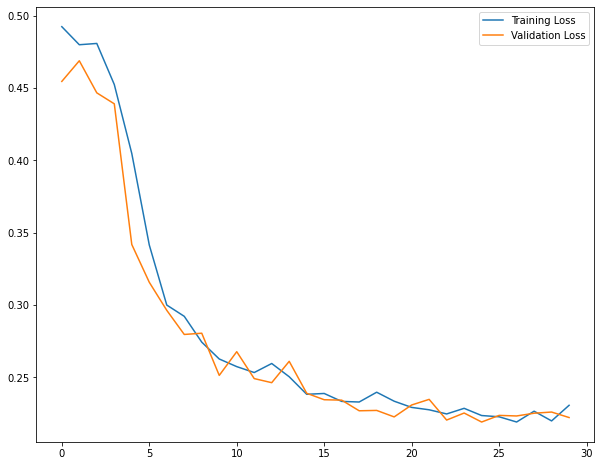

In [26]:
# plot training and validation loss
plt.plot(History.history['loss'], label = 'Training Loss')
plt.plot(History.history['val_loss'], label = 'Validation Loss')
plt.legend()

### Observations:
- Here validation loss is consistently found to be with training loss.
- Intially i tried out with different dropout values where validation loss sligthly lower with training loss. But dropout 0.2 is consitently good.
- Now predict the Anomaly in our Test Data by calculating the Mean Absolute Error(MAE) on the Training Data.
    - First, let’s get prediction on our training data. 
    - Then we evaluate the model on our test data.

In [27]:
# To detect anamoly we calculate mean absolute error
X_Train_pred = Model.predict(X_Train)

#Calculate loss for eachone of model predictions
Train_mae_loss = pd.DataFrame(np.mean(np.abs(X_Train_pred - X_Train), axis = 1), columns=['Error'])

# Evaluate model using Total Loss
Model.evaluate(X_Test, y_Test)

29/29 [==============================] - 0s 10ms/step - loss: 0.2460


0.24596141278743744

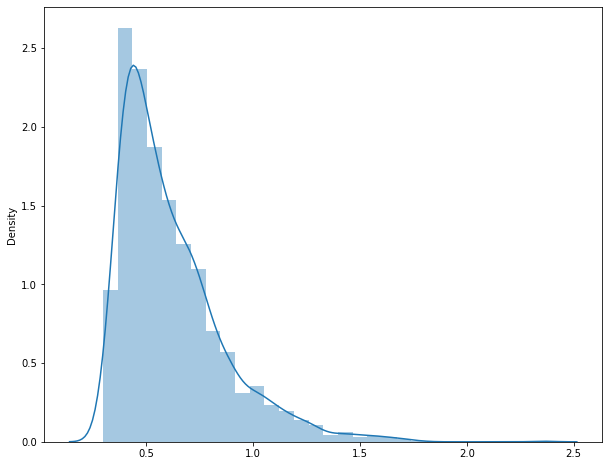

In [28]:
sns.distplot(Train_mae_loss, bins=30, kde=True);

### Results:
- The above graph give us a threshold as between 1.2 to 2.0 or less i.e as no value is larger than that.

- Now, let’s calculate the Mean Absolute Error (MAE) on test set in similar way to the training set and then plot the distribution loss.

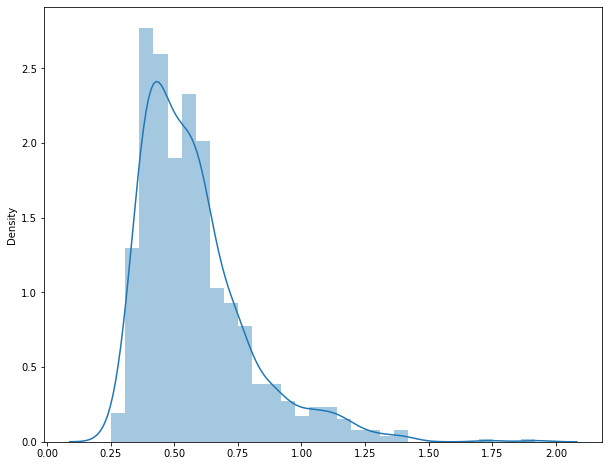

In [37]:
X_Test_pred = Model.predict(X_Test)
test_mae_loss = np.mean(np.abs(X_Test_pred - X_Test), axis=1)
sns.distplot(test_mae_loss, bins=30, kde=True);

## --------------------- Step 6. : Detect Anomalies On Data ------------------------

In [30]:
THRESHOLD = 1.2

test_score_df = pd.DataFrame(TestData[TimeSteps:].timestamp)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['demand'] = TestData[TimeSteps:].demand

In [31]:
test_score_df.head()

,timestamp,loss,threshold,anomaly,demand
2265,2018-03-15,0.603326,1.2,False,0.201215
2266,2018-03-16,0.667781,1.2,False,-0.016378
2267,2018-03-17,1.262342,1.2,True,-0.159398
2268,2018-03-18,0.917957,1.2,False,0.162477
2269,2018-03-19,0.485087,1.2,False,0.782723


In [32]:
test_score_df.tail()

,timestamp,loss,threshold,anomaly,demand
3188,2020-09-23,0.575391,1.2,False,-0.914110
3189,2020-09-24,0.607505,1.2,False,-1.172107
3190,2020-09-25,0.378095,1.2,False,-1.608638
3191,2020-09-26,0.646011,1.2,False,-1.751680
3192,2020-09-27,0.457578,1.2,False,-1.631139


In [33]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,timestamp,loss,threshold,anomaly,demand
2267,2018-03-17,1.262342,1.2,True,-0.159398
2302,2018-04-21,1.328074,1.2,True,-1.626314
2303,2018-04-22,1.256520,1.2,True,-1.917231
2578,2019-01-22,1.273025,1.2,True,1.211305
2597,2019-02-10,1.204972,1.2,True,-0.320205


In [39]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.timestamp, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test_score_df.timestamp, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

newplot_a.png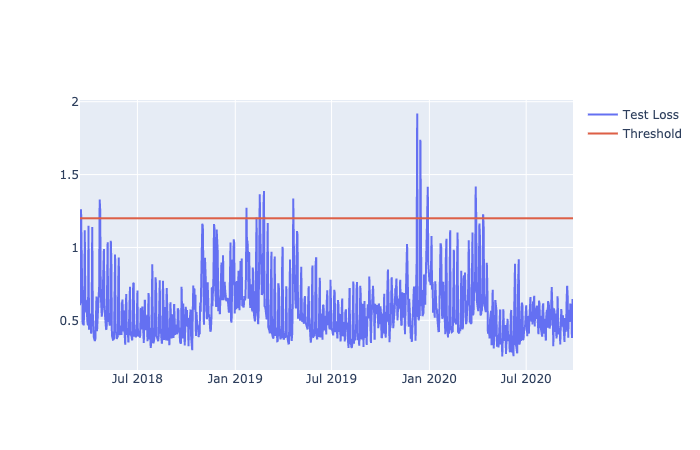

In [35]:
# create dataframe only for anamolies

anamolies = test_score_df[test_score_df.anomaly == True]
anamolies.head()

,timestamp,loss,threshold,anomaly,demand
2267,2018-03-17,1.262342,1.2,True,-0.159398
2302,2018-04-21,1.328074,1.2,True,-1.626314
2303,2018-04-22,1.256520,1.2,True,-1.917231
2578,2019-01-22,1.273025,1.2,True,1.211305
2597,2019-02-10,1.204972,1.2,True,-0.320205


In [40]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=TestData[TimeSteps:].timestamp, y=test_score_df.loss, mode='lines', name='Test Loss'))
fig.add_trace(go.Scatter(x=TestData[TimeSteps:].timestamp, y=test_score_df.threshold, mode='lines', name='Threshold'))
fig.update_layout(showlegend=True)
              

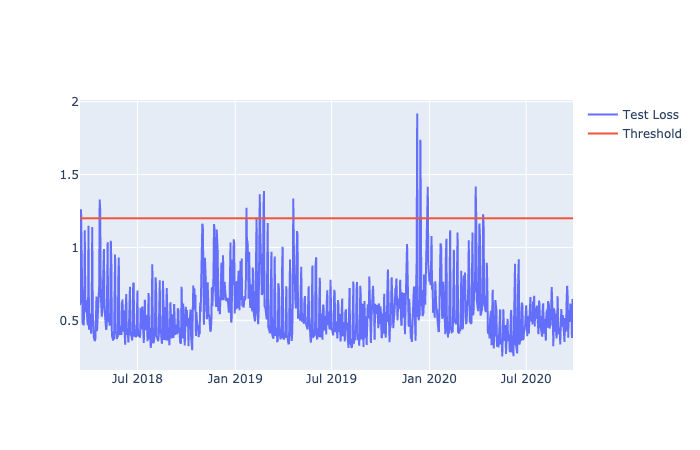

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=TestData[TimeSteps:].timestamp, y=scaler.inverse_transform(TestData[TimeSteps:].demand), mode='lines', name='demand'))

#plot line to indicate threshold
fig.add_trace(go.Scatter(x=anamolies.timestamp, y=scaler.inverse_transform(anamolies.demand), mode='markers', name='Anomaly'))
fig.update_layout(showlegend = True)
fig.show()

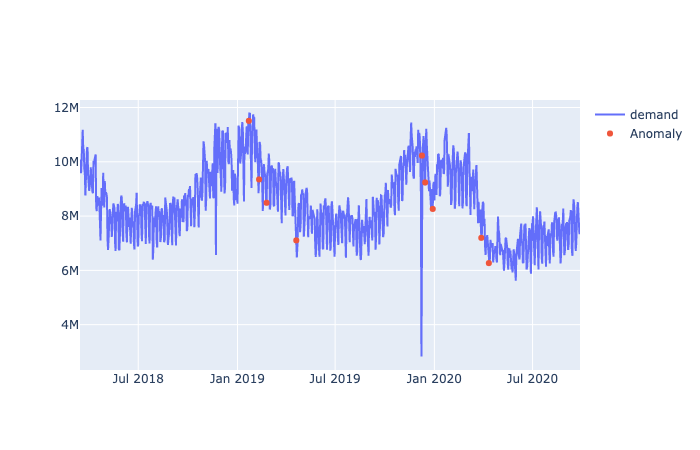

## Conclusion:
- As we decrease we here anomalies are less because due this pandameic electricity demand is consistently low.
- But still as we reduce the threshold size model able to predict consistent anomalies.